# Binary Semantic Segmentation: Cloud detection with U-net and Hub ☁
Author: Margaux Masson-Forsythe

## Imports

In [1]:
!pip install hub==1.3.5

In [2]:
import hub
from hub import Dataset, schema
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage import img_as_ubyte
from glob import glob  
import tensorflow as tf
import random
import pandas as pd
from PIL import Image
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tqdm import tqdm

## Load Data from Hub

In [3]:
print(tf.__version__)

2.5.0


In [4]:
tag = "margauxmforsythe/cloud-segmentation-dataset"

# Load the data
print("Load data...")
ds = Dataset(tag)

Load data...


In [5]:
ds.meta

{'.hub.dynamic_tensor': {'/image': {'shape': [5155, 384, 384, 4]},
  '/mask': {'shape': [5155, 384, 384, 1]}},
 '.zarray': {'/image': {'chunks': [4, 384, 384, 4],
   'compressor': {'acceleration': 1, 'id': 'lz4'},
   'dtype': '<f8',
   'fill_value': 0.0,
   'filters': None,
   'order': 'C',
   'shape': [5155, 384, 384, 4],
   'zarr_format': 2},
  '/mask': {'chunks': [15, 384, 384, 1],
   'compressor': {'acceleration': 1, 'id': 'lz4'},
   'dtype': '<f8',
   'fill_value': 0.0,
   'filters': None,
   'order': 'C',
   'shape': [5155, 384, 384, 1],
   'zarr_format': 2}},
 'meta_info': {},
 'name': None,
 'schema': {'items': {'image': {'chunks': None,
    'compressor': 'lz4',
    'dtype': 'float64',
    'max_shape': [384, 384, 4],
    'shape': [384, 384, 4],
    'type': 'Tensor'},
   'mask': {'chunks': None,
    'compressor': 'lz4',
    'dtype': 'float64',
    'max_shape': [384, 384, 1],
    'shape': [384, 384, 1],
    'type': 'Tensor'}},
  'type': 'SchemaDict'},
 'shape': [5155],
 'version'

In [6]:
ds.meta['schema']['items']['image']['shape']

[384, 384, 4]

In [7]:
ds.meta['schema']['items']['mask']['shape']

[384, 384, 1]

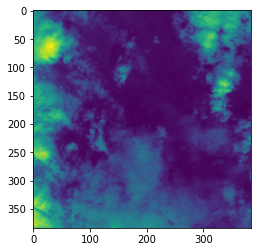

In [8]:
for i in range(len(ds)):  
  plt.imshow(ds["image"][i].compute()[:, :, 0])
  plt.show()
  break

## Hub dataset to Tensorflow Dataset

In [9]:
from timeit import default_timer as timer

In [10]:
my_schema = {
        "image": schema.Tensor(ds.meta['schema']['items']['image']['shape'], dtype="float"),
        "mask": schema.Tensor(ds.meta['schema']['items']['mask']['shape'], dtype="float")
    }

@hub.transform(schema=my_schema, scheduler="threaded", workers=6)
def normalize(samples):
  x = samples['image']
  # Normalize
  x = x / tf.reduce_max(x)
  y = samples['mask'] / 255
  return ({
    "image": x,
    "mask": y
  })

ds1 = normalize(ds)
# we choose to only use 100 images for training because of GPU limit capacity in Google Colab
image_count = 100
ds_tf = ds1[:image_count].to_tensorflow(include_shapes=True)

def to_model_fit(item):
    x = item["image"]
    y = item["mask"] 
    return (x, y)

ds_tf = ds_tf.map(lambda x: to_model_fit(x))

Computing the transformation in chunks of size 100: 100%|██████████| 100/100 [00:05<00:00, 19.6 items/s]


(384, 384, 4)
(384, 384, 1)
[0. 1.]


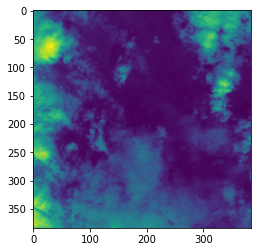

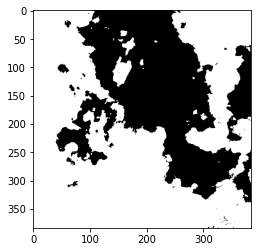

In [11]:
for img, label in ds_tf:
    print(img.shape)
    print(label.shape)
    print(np.unique(label))
    plt.imshow(img[:,:,0])
    plt.show()
    plt.imshow(label[:,:,0], cmap="gray")
    plt.show()
    break

In [12]:
train_size = int(0.8 * image_count)
val_size = int(0.1 * image_count)
test_size = int(0.1 * image_count)
batch_size = 6

ds_tf = ds_tf.shuffle(image_count)
test_ds = ds_tf.take(test_size)
train_ds = ds_tf.skip(test_size)
val_ds = train_ds.take(val_size)
train_ds = train_ds.skip(val_size)

print(f"{train_size} training images, {val_size} validation images and {test_size} test images. Batch size of {batch_size}")

train_ds = train_ds.shuffle(train_size)
train_ds = train_ds.batch(batch_size)

val_ds = val_ds.shuffle(val_size)
val_ds = val_ds.batch(batch_size)

test_ds = test_ds.batch(1)

80 training images, 10 validation images and 10 test images. Batch size of 6


## Model definition

In [13]:
def unet(pretrained_weights=None, input_shape=(256, 256, 1), num_classes=12):
    inputs = Input(input_shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)

    # model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Training

In [14]:
model = unet(input_shape = (384,384,4))

In [15]:
if not os.path.isdir("./checkpoints"):
    print("Create folder checkpoints")
    os.mkdir("./checkpoints")

In [16]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('./checkpoints/weights.epoch-{epoch:02d}-val-iou-{val_iou:.4f}.hdf5',
                                                 monitor='val_iou', 
                                                 mode='max', verbose=1,
                                                 save_best_only=True,
                                                 save_weights_only=True)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name="recall"), 
                       tf.keras.metrics.Precision(name="precision"), 
                       tf.keras.metrics.MeanIoU(num_classes=2, name='iou')]) 

In [18]:
model.fit(train_ds, 
          validation_data=val_ds, 
          epochs = 20,
          callbacks = [checkpoint_callback])

Epoch 1/20
14/14 [==============================] - 60s 3s/step - loss: 0.6421 - accuracy: 0.6533 - recall: 0.9054 - precision: 0.6109 - iou: 0.2418 - val_loss: 0.5562 - val_accuracy: 0.8256 - val_recall: 0.9794 - val_precision: 0.7149 - val_iou: 0.2879

Epoch 00001: val_iou improved from -inf to 0.28789, saving model to ./checkpoints/weights.epoch-01-val-iou-0.2879.hdf5
Epoch 2/20
14/14 [==============================] - 14s 945ms/step - loss: 0.5699 - accuracy: 0.7395 - recall: 0.8748 - precision: 0.6904 - iou: 0.2484 - val_loss: 0.4358 - val_accuracy: 0.8192 - val_recall: 0.9361 - val_precision: 0.8017 - val_iou: 0.1941

Epoch 00002: val_iou did not improve from 0.28789
Epoch 3/20
14/14 [==============================] - 13s 937ms/step - loss: 0.6417 - accuracy: 0.7195 - recall: 0.9226 - precision: 0.6399 - iou: 0.2649 - val_loss: 0.6937 - val_accuracy: 0.5407 - val_recall: 0.9984 - val_precision: 0.4364 - val_iou: 0.3222

Epoch 00003: val_iou improved from 0.28789 to 0.32215, savin

## Evaluation on test set

In [19]:
model.evaluate(test_ds)

10/10 [==============================] - 4s 60ms/step - loss: 0.2743 - accuracy: 0.8796 - recall: 0.7706 - precision: 0.9980 - iou: 0.2394


[0.2742657959461212,
 0.8796271681785583,
 0.7706074714660645,
 0.9980320930480957,
 0.23935343325138092]

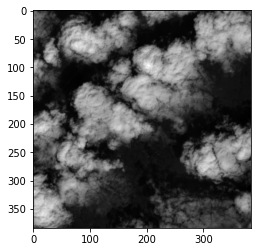

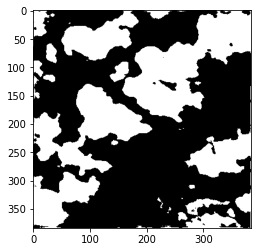

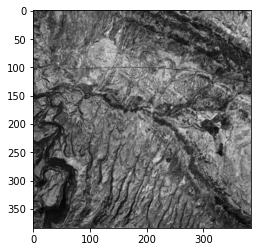

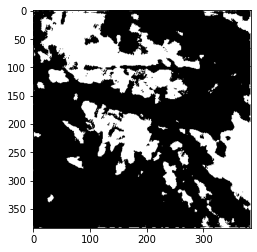

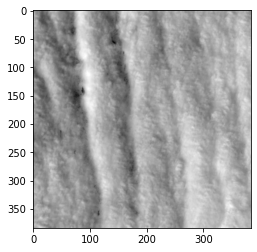

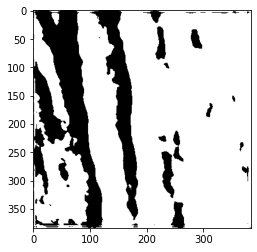

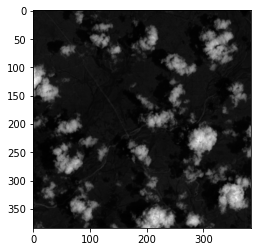

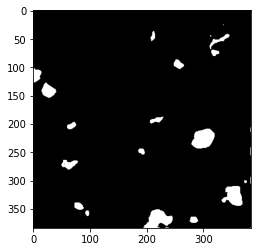

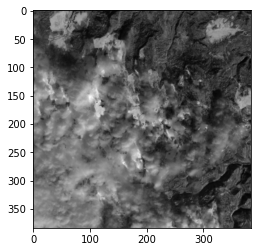

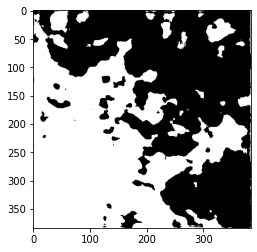

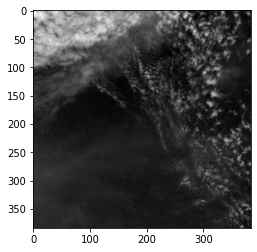

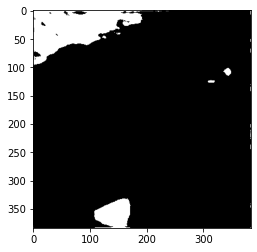

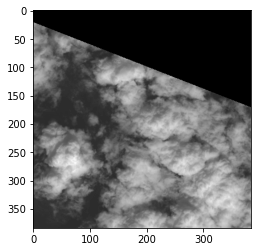

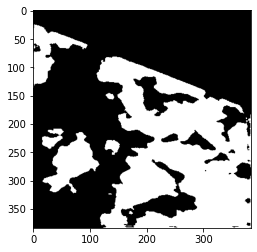

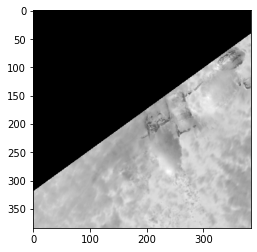

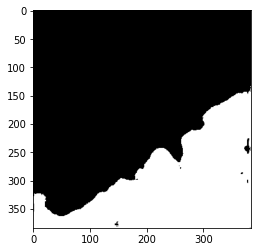

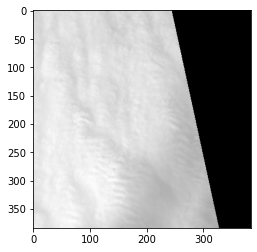

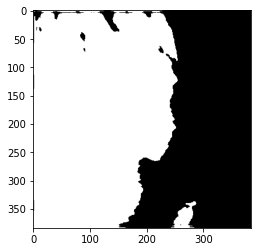

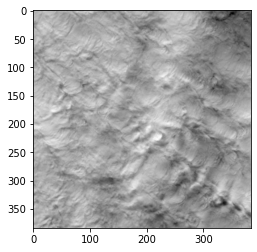

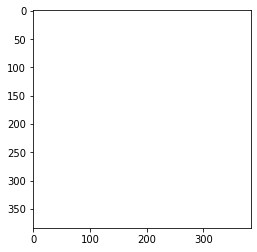

In [24]:
i = 0
model.load_weights('./checkpoints/weights.epoch-13-val-iou-0.3476.hdf5') # best weights
for img, label in test_ds:
  pred = (model.predict(img)[0] > 0.5).astype(np.uint8)
  plt.imshow(img[0][:,:,0], cmap="gray")
  plt.show()
  plt.imshow(pred[:,:,0], cmap="gray")
  plt.show()
  i = i + 1
  if i > 20:
    break